In [7]:
import numpy as np
from ddeint import ddeint
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

In [23]:
# Fixed parameters (same across species):
alpha = 1            # Max transcription rate
P0 = 50,                # Repression threshold
n = 2                   # Hill coefficient

#reference data of mouse to scale the parameters
params_ref = {
    "name": "Mouse",
    "T_period": 122,  # Observed period (minutes)
    "beta_P": np.log(2)/24,  # Protein degradation rate (1/min)
    "beta_M": 0.03,          # mRNA degradation rate (1/min)
    "gamma": 0.1,            # Translation rate (1/min)
    "tau": 24,               # Transcriptional delay (minutes)
}

In [24]:
#experimental data of different species from the paper

human_data = {
    "name": "Human'",
    "T_period": 322,         # Observed period (minutes)
    "P_tau": 54,               # From Figure 3C
    "beta_P": np.log(2)/50   # Protein half-life ~50 min (Page 6)
}

rabbit_data = {
    "name": "Rabbit",
    "T_period": 153,         # Observed period (minutes)
    "P_tau": 24,               # From Figure 3C
    "beta_P": np.log(2)/24   # Protein half-life (Page 6)
}

imagine1_data = {  
    # This is a made-up species, have same period and tau as rabbit but twice protein half-life
    "name": "Imagine Spiecies 1",
    "T_period": 153,         # Observed period (minutes)
    "P_tau": 24,               # From Figure 3C
    "beta_P": np.log(2)/ 48  # Protein half-life
}

imagine2_data = {  
    # This is a made-up species, have same period and half-life as rabbit but twice tau
    "name": "Imagine Species 2",
    "T_period": 153,         # Observed period (minutes)
    "P_tau": 48,               # From Figure 3C
    "beta_P": np.log(2)/24  # Protein half-life
}

cattle_data = {
    "name": "Cattle",
    "T_period": 238,         # Observed period (minutes)
    "P_tau": 37,               # From Figure 3C
    "beta_P": np.log(2)/33   # Protein half-life  (Page 6)
}

rhinoceros_data = {
    "name": "Rhinoceros",
    "T_period": 236,         # Observed period (minutes)
    "P_tau": 36,               # From Figure 3C
    "beta_P": np.log(2)/32   # Protein half-life  (Page 6)
}

marmoset_data = {
    "name": "marmoset",
    "T_period": 388,         # Observed period (minutes)
    "P_tau": 54,               # From Figure 3C
    "beta_P": np.log(2)/46   # Protein half-life (Page 6)
}



In [25]:
def simulation(y):
   # Parameters for Hes7 dynamics
   # Unpack parameters
   k = human_data["T_period"] / params_ref["T_period"]
   P_tau = y["P_tau"]
   species = y["name"]
   beta_P = y["beta_P"]
   beta_M = float(params_ref["beta_M"]/k)
   gamma = float(params_ref["gamma"]/k)
   

   sigma_M = 0.2            # mRNA noise intensity
   sigma_P = 0.05           # Protein noise intensity
   # Time points
   dt = 10                   # Time step
   T = 10000                  # Total simulation time
   timesteps = int(T / dt)
   timespan = np.linspace(0, T, timesteps)
   # Initialise variables
   M = np.zeros(timesteps)  # Hes7 mRNA
   P = np.zeros(timesteps)  # Hes7 protein
   M_clear = np.zeros(timesteps)  # Hes7 mRNA without noise
   P_clear = np.zeros(timesteps)  # Hes7 protein without noise
   # Initial conditions
   M[0] = 3
   P[0] = 100
   M_clear[0] = 3
   P_clear[0] = 100
   

   for t in range(1,timesteps):     
      dW_M = np.random.randn() * np.sqrt(dt)  # Noise for Hes7 mRNA
      dW_P = np.random.randn() * np.sqrt(dt)  # Noise for Hes7 protein
      # Solve system of SDEs numerically using the Euler-Maruyama method
      dM = (alpha / (1 + (P[t - P_tau - 1] / P0 ) ** n) - beta_M * M[t - 1]) *dt + sigma_M * dW_M 
      dP = (gamma * M[t - 1] - beta_P * P[t - 1]) * dt + sigma_P * dW_P
      dM_clear = (alpha / (1 + (P_clear[t - P_tau - 1] / P0 ) ** n) - beta_M * M_clear[t - 1]) *dt #without noise, for the peak calculation
      dP_clear = (gamma * M_clear[t - 1] - beta_P * P_clear[t - 1]) * dt 
      # Ensure mRNA and protein values cannot be negative (would not make biophysical sense)
      M[t] = max(M[t - 1] + dM, 0)
      P[t] = max(P[t - 1] + dP, 0)
      M_clear[t] = max(M_clear[t - 1] + dM_clear, 0)
      P_clear[t] = max(P_clear[t - 1] + dP_clear, 0)

   # Find peaks in the protein concentration
   peaks, _ = find_peaks(P_clear)
   peak = P_clear[peaks]
   damping = np.mean(peak[1:] / peak[:-1])   # Damping factor

   peak_times = timespan[peaks]
   periods = np.diff(peak_times)
   average_period = np.mean(periods)
   std_period = np.std(periods)


   # Plot the results
   plt.figure(figsize=(10, 6))
   plt.subplot(2, 1, 1)
   plt.plot(timespan, M, label=f"HES7 mRNA of {species}", color='#015493')
   plt.xlabel("Time (minutes)", fontsize=12)
   plt.ylabel("Concentration (arbitrary units)", fontsize=12)
   plt.legend()
   plt.grid(True)
   plt.title(f"Hes7 mRNA dynamics of {species}")

   plt.subplot(2, 1, 2)
   plt.plot(timespan, P, label=f"HES7 Protein of {species}", color='#F4A99B')
   plt.xlabel("Time (minutes)", fontsize=12)
   plt.ylabel("Concentration (arbitrary units)", fontsize=12)
   plt.legend()
   plt.grid(True)
   plt.title(f"Hes7 protein dynamics of {species}")

   plt.tight_layout()
   plt.show()
   return average_period, std_period, damping

C:\Users\saza7\AppData\Local\Temp\ipykernel_37616\3908803436.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M[t] = max(M[t - 1] + dM, 0)
C:\Users\saza7\AppData\Local\Temp\ipykernel_37616\3908803436.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M_clear[t] = max(M_clear[t - 1] + dM_clear, 0)


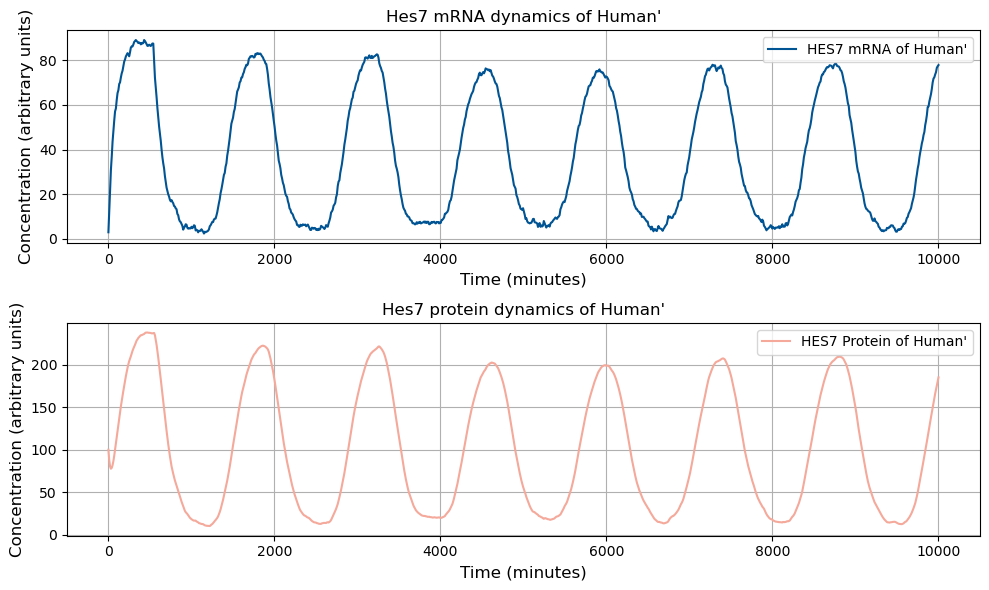

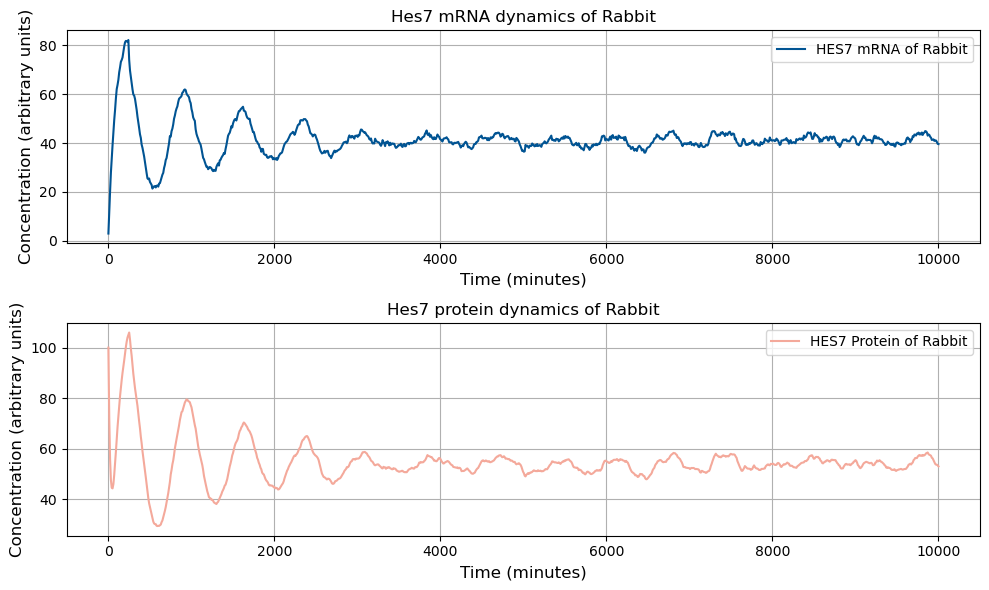

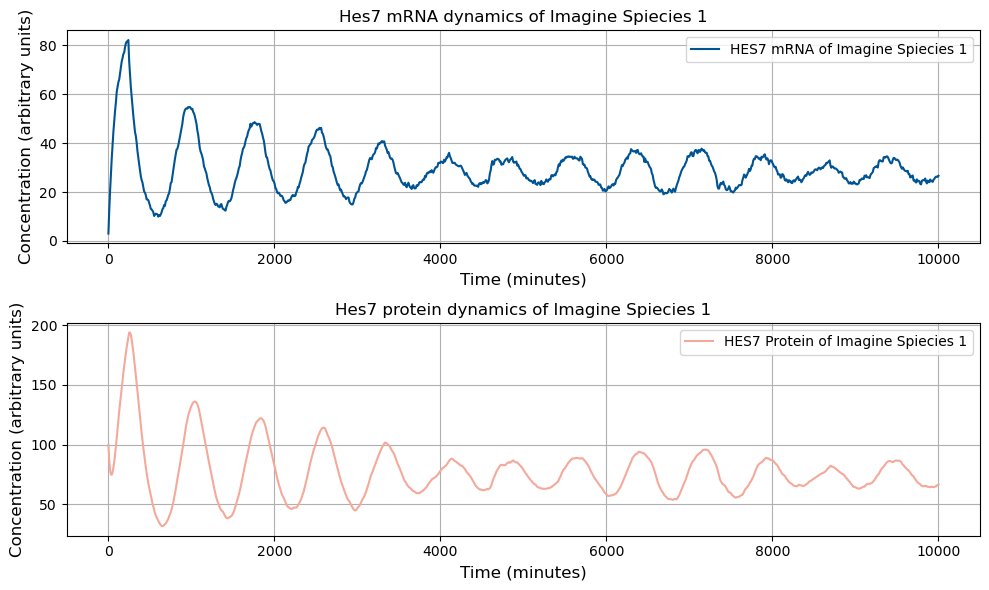

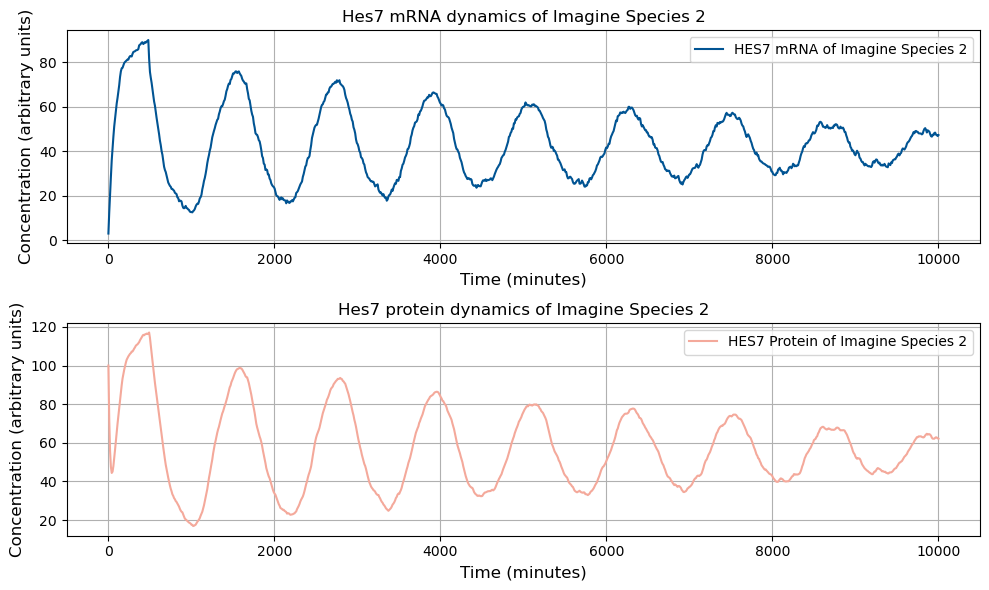

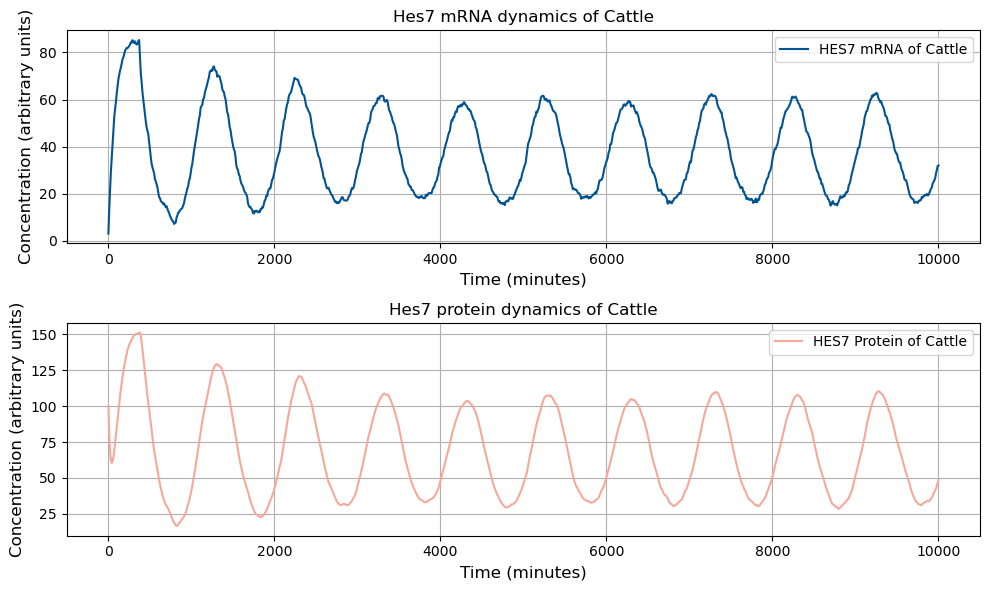

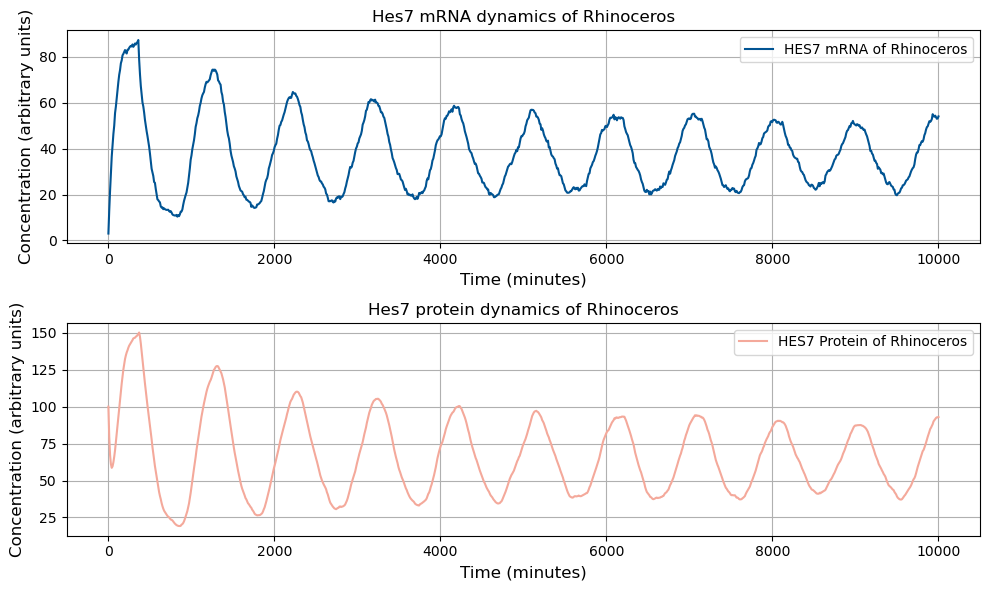

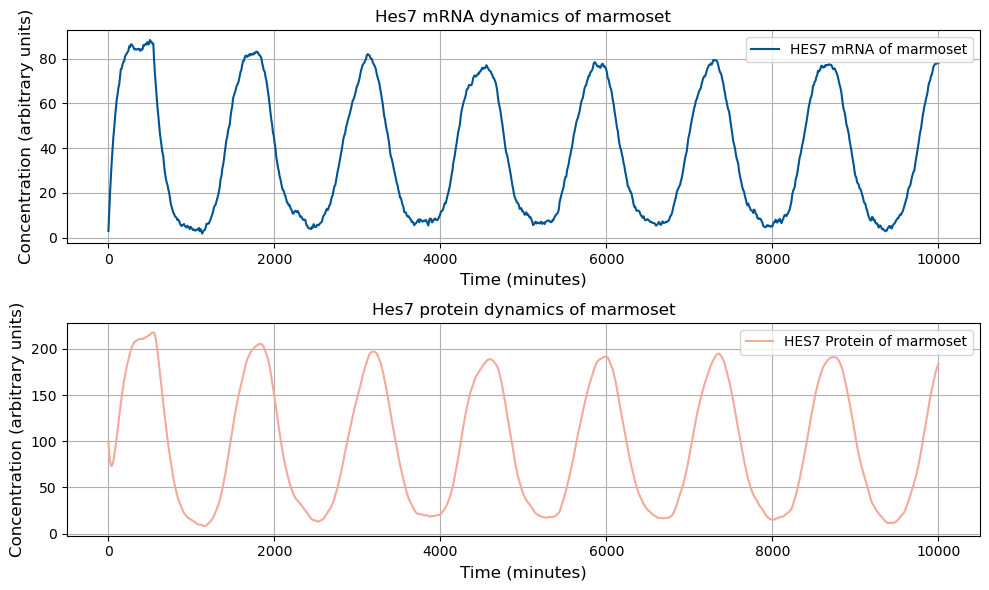

(1378.0447113780447, 34.51478289218753, 0.9780640390216325)
(706.860706860707, 4.869912466571689, 0.9518299442784165)
(769.1024357691025, 3.730510472972288, 0.9458620345809745)
(1183.6836836836837, 31.555355888184497, 0.9395937601483839)
(992.1032143254365, 18.54446891395068, 0.954384904147485)
(969.8587476365254, 17.934062391944327, 0.9503765839695723)
(1364.6980313646982, 33.03134780317537, 0.9766233168435313)


In [26]:
human_stats = simulation(human_data)

rabbit_stats = simulation(rabbit_data)

imagine1_stats = simulation(imagine1_data)

imagine2_stats = simulation(imagine2_data)

cattle_stats=simulation(cattle_data)

rhinoceros_stats=simulation(rhinoceros_data)

marmoset_stats = simulation(marmoset_data)

print(human_stats)
print(rabbit_stats)
print(imagine1_stats)
print(imagine2_stats)
print(cattle_stats)
print(rhinoceros_stats)
print(marmoset_stats)

# plot a figure to compare the periods of different species
periods = np.array([rabbit_stats[0], imagine1_stats[0], rhinoceros_stats[0], cattle_stats[0], imagine2_stats[0], marmoset_stats[0], human_stats[0]])
std_periods = np.array([rabbit_stats[1], imagine1_stats[1], rhinoceros_stats[1], cattle_stats[1], imagine2_stats[1], marmoset_stats[1], human_stats[1]])
P_tau = np.array([rabbit_data["P_tau"], imagine1_data["P_tau"], rhinoceros_data["P_tau"], cattle_data["P_tau"], imagine2_data["P_tau"], marmoset_data["P_tau"], human_data["P_tau"]])
beta_P = np.array([rabbit_data["beta_P"], imagine2_data["beta_P"], rhinoceros_data["beta_P"], cattle_data["beta_P"], imagine1_data["beta_P"], marmoset_data["beta_P"], human_data["beta_P"]])
damping_effects = np.array([rabbit_stats[2], imagine2_stats[2], rhinoceros_stats[2], cattle_stats[2], imagine1_stats[2], marmoset_stats[2], human_stats[2]])


Fitted line: y = 20.724581569999156x + 231.94891944691935
Covariance matrix: [[ 1.00094615e+00 -3.96088690e+01]
 [-3.96088690e+01  1.70918704e+03]]


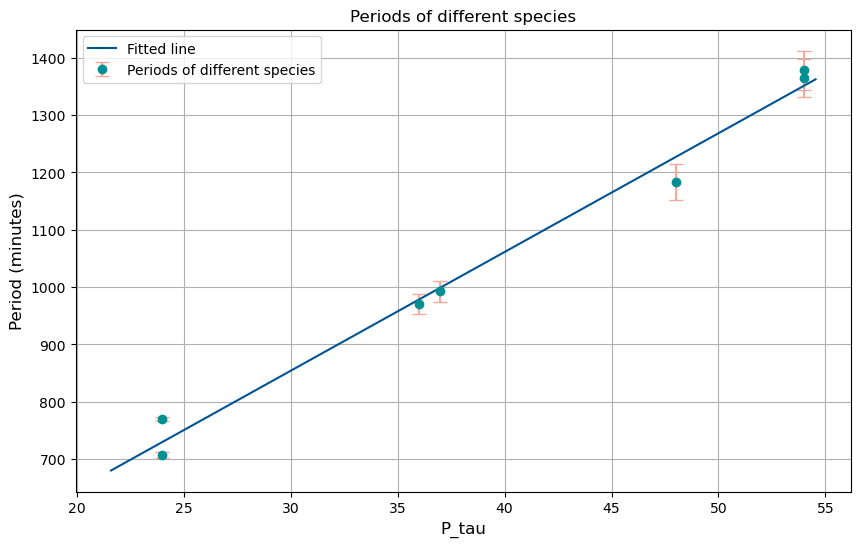

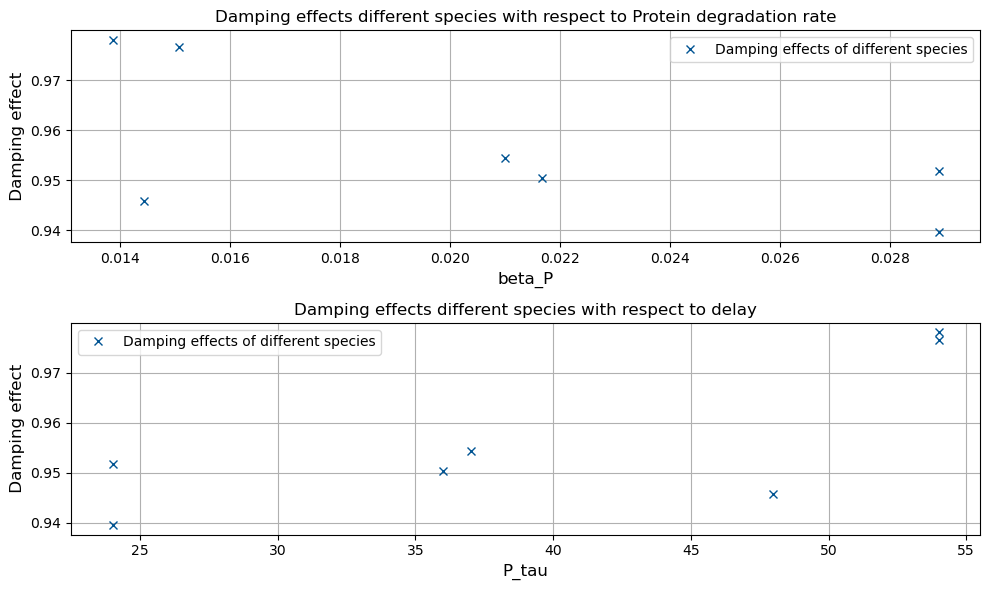

Average period of Human: 1378.0447113780447, Standard deviation of period of Human: 34.51478289218753, Damping effect: 0.9780640390216325
Average period of Rabbit: 706.860706860707, Standard deviation of period of Rabbit: 4.869912466571689, Damping effect: 0.9518299442784165
Average period of Imagine Species 1: 769.1024357691025, Standard deviation of period: 3.730510472972288, Damping effect: 0.9458620345809745
Average period of Imagine Species 2: 1183.6836836836837, Standard deviation of period: 31.555355888184497, Damping effect: 0.9395937601483839
Average period of Cattle: 992.1032143254365, Standard deviation of period of Cattle: 18.54446891395068, Damping effect: 0.954384904147485
Average period of Rhinoceros: 969.8587476365254, Standard deviation of period of Rhinoceros: 17.934062391944327, Damping effect: 0.9503765839695723
Average period of Marmoset: 1364.6980313646982, Standard deviation of period of Marmoset: 33.03134780317537, Damping effect: 0.9766233168435313


In [27]:

#fit period-P-tau by linear regression
p, cov= np.polyfit(P_tau, periods, 1, cov=True) #fit the data
x = np.linspace(0.9*min(P_tau),1.01*max(P_tau),100) #generate an array of x values
fit_line = np.poly1d(p) #generate y values
print(f'Fitted line: y = {p[0]}x + {p[1]}')
print(f'Covariance matrix: {cov}')

plt.figure(figsize=(10, 6))
plt.errorbar(P_tau, periods, yerr=std_periods, fmt='o', color='#019092', ecolor='#F4A99B', capsize=5, label='Periods of different species')
plt.plot(x, fit_line(x), color='#015493', label='Fitted line')
plt.xlabel("P_tau", fontsize=12)
plt.ylabel("Period (minutes)", fontsize=12)
plt.legend()
plt.grid(True)
plt.title("Periods of different species")
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(beta_P, damping_effects, 'x', color='#015493', label='Damping effects of different species')
plt.xlabel("beta_P", fontsize=12)
plt.ylabel(" Damping effect ", fontsize=12)
plt.legend()
plt.grid(True)
plt.title("Damping effects different species with respect to Protein degradation rate")

plt.subplot(2, 1, 2)
plt.plot(P_tau, damping_effects, 'x', color='#015493', label='Damping effects of different species')
plt.xlabel("P_tau", fontsize=12)
plt.ylabel(" Damping effect ", fontsize=12)
plt.legend()
plt.grid(True)
plt.title("Damping effects different species with respect to delay")

plt.tight_layout()
plt.show()

print(f'Average period of Human: {human_stats[0]}, Standard deviation of period of Human: {human_stats[1]}, Damping effect: {human_stats[2]}')
print(f'Average period of Rabbit: {rabbit_stats[0]}, Standard deviation of period of Rabbit: {rabbit_stats[1]}, Damping effect: {rabbit_stats[2]}')
print(f'Average period of Imagine Species 1: {imagine1_stats[0]}, Standard deviation of period: {imagine1_stats[1]}, Damping effect: {imagine1_stats[2]}')
print(f'Average period of Imagine Species 2: {imagine2_stats[0]}, Standard deviation of period: {imagine2_stats[1]}, Damping effect: {imagine2_stats[2]}')
print(f'Average period of Cattle: {cattle_stats[0]}, Standard deviation of period of Cattle: {cattle_stats[1]}, Damping effect: {cattle_stats[2]}')
print(f'Average period of Rhinoceros: {rhinoceros_stats[0]}, Standard deviation of period of Rhinoceros: {rhinoceros_stats[1]}, Damping effect: {rhinoceros_stats[2]}')
print(f'Average period of Marmoset: {marmoset_stats[0]}, Standard deviation of period of Marmoset: {marmoset_stats[1]}, Damping effect: {marmoset_stats[2]}')